In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "k"

In [2]:
targets = pd.read_csv(
    "data/main/stock_prices_pruned.csv", index_col="DATE", parse_dates=True
)

inputs = pd.read_csv(
    "data/main/economic_data_with_ffq.csv", index_col="DATE", parse_dates=True
)

In [3]:
targets.shape, inputs.shape

((1393, 30), (1393, 28))

In [4]:
targets_s = targets.pct_change()[1:]
inputs_n = inputs[1:]

targets_s.shape, inputs_n.shape

((1392, 30), (1392, 28))

In [5]:
stocks = targets_s.columns
econ_indicators = inputs_n.columns

In [6]:
df = pd.merge(inputs_n, targets_s, on="DATE")
df.head()

,GDP,CPIAUCNS,UNRATE,FEDFUNDS,DTWEXM,T10Y2Y,M2,PCE,HOANBS,BUSINV,...,POOL,QCOM,RMD,ROST,STZ,TJX,TSCO,TYL,UNH,WST
DATE,,,,,,,,,,,,,,,,,,,,,
1997-01-10,8374.668077,159.2,5.28,5.238,89.02160,0.580,3830.4,5415.68,98.189538,1008371.2,...,-0.048193,0.115987,0.023256,0.009951,0.012821,0.016712,-0.018182,0.000000,-0.010753,-0.004484
1997-01-17,8386.681154,159.3,5.26,5.226,89.46776,0.558,3833.9,5420.26,98.226077,1008957.4,...,0.025316,0.101124,0.011364,-0.108375,-0.037975,-0.057534,0.000000,0.000000,-0.059782,0.009552
1997-01-24,8398.694231,159.4,5.24,5.214,90.67085,0.550,3834.9,5424.84,98.262615,1009543.6,...,0.037037,0.140306,-0.022472,-0.016574,-0.017544,-0.040697,-0.024691,0.125000,0.095376,-0.008969
1997-01-31,8410.707308,159.5,5.22,5.202,91.54040,0.592,3836.7,5429.42,98.299154,1010129.8,...,0.023810,0.002237,0.005747,-0.078653,0.004464,-0.036364,0.025316,0.000000,0.029023,0.004525
1997-02-07,8422.720385,159.6,5.20,5.190,92.11536,0.572,3838.2,5434.00,98.335692,1010716.0,...,0.000000,0.035714,0.097143,0.073171,-0.017778,0.001822,0.037037,-0.111111,-0.041026,0.009009


In [7]:
train_size = .7
slice_idx = int(train_size * len(df))
train_set, test_set = df[:slice_idx], df[slice_idx:]

train_set.shape, test_set.shape

((974, 58), (418, 58))

In [51]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import r2_score, mean_absolute_error
# from sklearn.model_selection import GridSearchCV
# from tqdm import tqdm

# target_avg = df[stocks].sum(axis=1) / len(stocks)
# inputs_all_time = df[econ_indicators]

# rf = RandomForestRegressor(random_state=42)

# rf_param_grid = rf_param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt'],
#     'bootstrap': [True, False]
# }

# grid_search_rf = GridSearchCV(estimator=rf, param_grid=rf_param_grid, 
#                            cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# grid_search_rf.fit(inputs_all_time, target_avg)

# rf_best_params = grid_search_rf.best_params_
# rf_best = grid_search_rf.best_estimator_

Fitting 3 folds for each of 324 candidates, totalling 972 fits


In [13]:
import pickle

with open("models/rf_fi.pkl", "rb") as f:
    rf_dict = pickle.load(f)

rf_best = rf_dict["model"]

print(rf_best)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      random_state=42)


In [47]:
feature_importances = pd.Series(
    rf_best.feature_importances_,
    index=econ_indicators,
    name="feature_importances"
).sort_values(ascending=False)

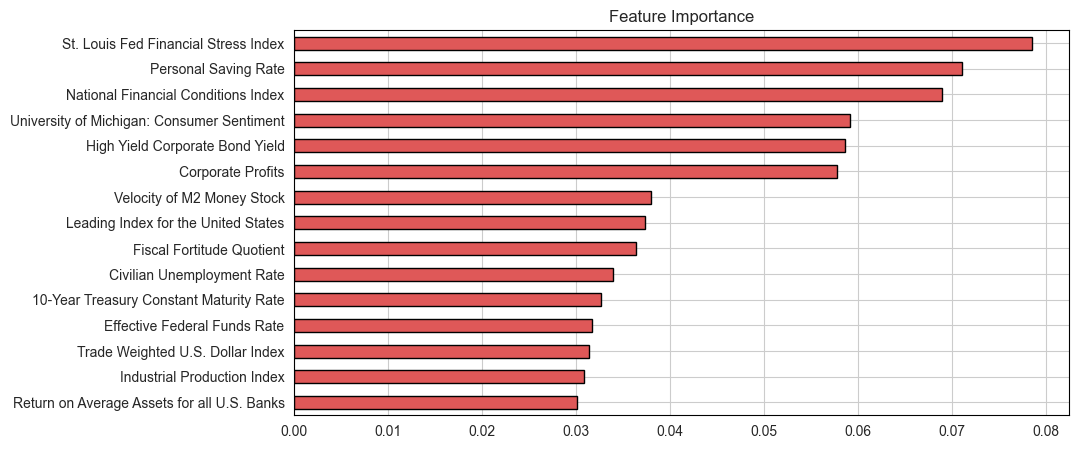

In [61]:
with open("data/base/economic_indicators.pkl", "rb") as f:
    indicator_dict = pickle.load(f)

indicator_dict = {v: k for k, v in indicator_dict.items()}
indicator_dict["FFQ"] = "Fiscal Fortitude Quotient"
feature_importances_rename = feature_importances.copy()
feature_importances_rename.index = [indicator_dict[k] for k in feature_importances.index]
feature_importances_rename[:15].iloc[::-1].plot.barh(
    color="#DF5858", title="Feature Importance", figsize=(10, 5), edgecolor="k"
)
plt.show()

In [72]:
selected_features = list(feature_importances[:15].index)
df_pruned = df[selected_features + list(stocks)]
df_pruned.head()

,STLFSI,PSAVERT,NFCI,UMCSENT,BAMLH0A0HYM2,CP,WM2NS,USSLIND,FFQ,UNRATE,...,POOL,QCOM,RMD,ROST,STZ,TJX,TSCO,TYL,UNH,WST
DATE,,,,,,,,,,,,,,,,,,,,,
1997-01-10,0.774,6.2,-0.69206,97.86,3.112,548.187077,3874.1,1.652,0.203694,5.28,...,-0.048193,0.115987,0.023256,0.009951,0.012821,0.016712,-0.018182,0.000000,-0.010753,-0.004484
1997-01-17,0.732,6.2,-0.69405,98.32,3.052,549.610154,3861.2,1.694,0.201802,5.26,...,0.025316,0.101124,0.011364,-0.108375,-0.037975,-0.057534,0.000000,0.000000,-0.059782,0.009552
1997-01-24,0.715,6.2,-0.70223,98.78,2.996,551.033231,3841.2,1.736,0.199910,5.24,...,0.037037,0.140306,-0.022472,-0.016574,-0.017544,-0.040697,-0.024691,0.125000,0.095376,-0.008969
1997-01-31,0.747,6.2,-0.71448,99.24,2.954,552.456308,3804.4,1.778,0.198018,5.22,...,0.023810,0.002237,0.005747,-0.078653,0.004464,-0.036364,0.025316,0.000000,0.029023,0.004525
1997-02-07,0.700,6.2,-0.72842,99.70,3.060,553.879385,3820.8,1.820,0.196126,5.20,...,0.000000,0.035714,0.097143,0.073171,-0.017778,0.001822,0.037037,-0.111111,-0.041026,0.009009


In [79]:
feature_importances

STLFSI             0.078532
PSAVERT            0.071072
NFCI               0.068924
UMCSENT            0.059138
BAMLH0A0HYM2       0.058551
CP                 0.057767
WM2NS              0.037903
USSLIND            0.037284
FFQ                0.036370
UNRATE             0.033872
GS10               0.032587
FEDFUNDS           0.031687
DTWEXM             0.031375
INDPRO             0.030802
USROA              0.030048
W875RX1            0.027000
T10Y2Y             0.026323
REALLN             0.025125
HOANBS             0.025104
CPIAUCNS           0.024639
A939RX0Q048SBEA    0.023973
PCE                0.023304
BUSINV             0.022846
GDPC1              0.022081
M2                 0.021665
GDP                0.021173
PAYEMS             0.020457
OILPRICE           0.020399
Name: feature_importances, dtype: float64

In [73]:
df_pruned.to_csv("data/main/master_df.csv")

### Most Important Features Determining Average Returns of 30 S&P 500 Stocks

- **STLFSI (St. Louis Fed Financial Stress Index)**: At the top of the list, this index encapsulates the overall stress in the financial system, including credit markets, equities, and interbank systems. A high STLFSI typically signifies that financial conditions are tightening, which could constrain capital availability and increase borrowing costs for companies. This could ultimately affect the stock prices of companies dependent on external financing.

- **PSAVERT (Personal Saving Rate)**: This metric reflects the percentage of disposable income that households are saving. A high saving rate could imply low consumer spending, which is a critical driver of economic growth. For consumer-centric sectors like retail, consumer goods, and even technology, a high personal saving rate could indicate headwinds in stock performance.

- **NFCI (National Financial Conditions Index)**: This is a comprehensive measure of U.S. financial conditions, including risk, credit, and leverage subindices. It's telling us that broader financial conditions have a substantial impact on the market's aggregate stock performance. A restrictive financial environment could lead to reduced lending, affecting both consumer and business spending, thereby influencing stock prices.

- **UMCSENT (Consumer Sentiment)**: A reflection of consumer confidence, this metric can be a leading indicator for consumer spending. High consumer sentiment usually precedes increased consumer spending, which benefits a wide array of sectors. Conversely, low sentiment could signify an upcoming contraction in consumer spending, affecting the revenue streams for companies in consumer-focused sectors.

- **BAMLH0A0HYM2 (High Yield Corporate Bond Yield)**: This indicates the yield on high-risk corporate bonds and serves as an indicator of investor appetite for risk. A rising yield could suggest investors are demanding higher returns for the increased credit risk they are taking, which might be a harbinger of economic downturns. Companies in more volatile sectors may see their stock prices impacted more significantly by changes in this yield.

- **CP (Commercial Paper)**: This short-term debt instrument is often used by companies for immediate funding needs. A higher importance of CP could indicate that short-term liquidity conditions in the market have a marked impact on stock prices. If companies struggle to issue commercial paper at reasonable rates, they may face liquidity issues, affecting their operational capabilities and stock prices.

- **WM2NS (M2 Money Supply Without Seasonal Adjustments)**: Reflects the total amount of money in circulation and in deposits. A change in money supply could lead to inflationary or deflationary pressures, which could influence interest rates and, in turn, the cost of capital for companies, affecting their valuation and stock price.

- **USSLIND (U.S. Leading Index)**: A composite index designed to forecast economic activity. A rising leading index suggests that economic conditions are improving, which is likely to support corporate earnings and stock prices. Conversely, a declining index could indicate an upcoming economic downturn and lower stock prices.

- **FFQ (Financial Fortitude Quotient)**: This custom metric is a composite score that encapsulates various facets of economic conditions such as Gross Domestic Product, Unemployment Rate, Inflation, Federal Funds Rate, and Oil Prices. Each of these components is transformed using specified piecewise functions to create normalized scores. These are then averaged to compute the FFQ. The metric aims to provide a holistic measure of economic health and resilience. Its significance in the feature importance list suggests that this aggregated measure has a non-negligible impact on stock prices, serving as a comprehensive indicator for gauging market conditions.

- **UNRATE (Unemployment Rate)**: High unemployment can lead to decreased consumer spending and can be a sign of a weakening economy. Companies in sectors sensitive to economic cycles may see reduced earnings, leading to lower stock prices

- **GS10 (10-Year Treasury Constant Maturity Rate)**: This is often seen as a benchmark for risk-free long-term investment and serves as an indicator of investor confidence. When the 10-year rate rises, it usually means that investors are optimistic about the economy but also expect inflation, which could lead to tighter monetary policy. The opposite is true when the rate falls. Companies heavily dependent on debt for operations or expansion may see their borrowing costs rise, affecting their profit margins and, in turn, their stock prices.

- **FEDFUNDS (Federal Funds Rate)**: This is the interest rate at which banks lend to each other overnight and serves as a base rate for all other interest rates in the economy. When the Federal Reserve raises this rate, it often leads to higher interest rates throughout the economy, increasing the cost of borrowing for both consumers and corporations. This can lead to reduced capital spending and consumer expenditure, which can negatively impact stock prices.

- **DTWEXM (Trade Weighted U.S. Dollar Index)**: This index measures the value of the U.S. dollar against a basket of foreign currencies. A strong dollar can make U.S. products more expensive for foreign buyers, potentially reducing export revenue for companies with significant overseas markets. Conversely, a weaker dollar can boost exports but may also lead to inflationary pressures.

- **INDPRO (Industrial Production)**: This index measures the total output of U.S. factories, mines, and utilities. It's a broad measure of economic activity in the industrial sector. A rising INDPRO suggests increased production, which often correlates with higher corporate earnings and, by extension, higher stock prices. A declining INDPRO could indicate reduced economic activity and could foretell a recession, thereby affecting stock prices negatively.

- **USROA (U.S. Return on Assets)**: This ratio measures how effectively companies are using their assets to generate earnings. A higher ratio indicates efficient asset utilization, which generally translates to better financial performance and potentially higher stock prices. Conversely, a declining USROA could indicate that companies are struggling to use their assets effectively, which could lead to reduced profitability and lower stock prices.

The array of impactful features underscores the intricacy of market dynamics affecting stock performance. From the stress levels in the financial system to the nuances of consumer saving and sentiment, the drivers are multifaceted and deeply interconnected. Add to this the importance of more straightforward economic indicators like industrial production and unemployment rates, and the picture becomes even more complex. The influence of interest rates—both short-term like the Federal Funds Rate and long-term like the 10-Year Treasury—indicates the market's sensitivity to monetary policy shifts. This extends to aspects of global economic conditions as well, as evidenced by the inclusion of trade-weighted U.S. dollar index, which speaks to the market's vulnerability to international trade dynamics. It's a rich tapestry of factors that range from the psychology of individual consumers to policies set by central banks and everything in between. This intricate landscape suggests that any strategy for stock portfolio management would need to be equally nuanced and adaptable to a wide range of economic conditions and indicators.